## <font color='darkblue'>Preface</font>
([article source](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_rbm_logistic_classification.html)) <b><font size='3ptx'>For greyscale image data where pixel values can be interpreted as degrees of blackness on a white background, like handwritten digit recognition, the Bernoulli Restricted Boltzmann machine model ([BernoulliRBM](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.BernoulliRBM.html#sklearn.neural_network.BernoulliRBM)) can perform effective non-linear feature extraction.</font></b>

In [38]:
import numpy as np

from keras.datasets import mnist
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

from sklearn import datasets
from sklearn.preprocessing import minmax_scale

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn import metrics

### <font color='darkgreen'>Introduction of `Bernoulli Restricted Boltzmann Machine (RBM).`</font>
A Restricted Boltzmann Machine with binary visible units and binary hidden units. Parameters are estimated using Stochastic Maximum Likelihood (SML), also known as Persistent Contrastive Divergence (PCD) 

The time complexity of this implementation is $O(d^2)$ assuming `d` ~ `n_features` ~ `n_components`.

Read more in the [User Guide](https://scikit-learn.org/stable/modules/neural_networks_unsupervised.html#rbm).

### <font color='darkgreen'>Generate data</font>
In order to learn good latent representations from a small dataset, we artificially generate more labeled data by perturbing the training data with linear shifts of 1 pixel in each direction.

In [28]:
# Loading raw dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [29]:
print(f'train_X.shape={train_X.shape}; test_X.shape={test_X.shape}')
train_X[0]

train_X.shape=(60000, 28, 28); test_X.shape=(10000, 28, 28)


array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

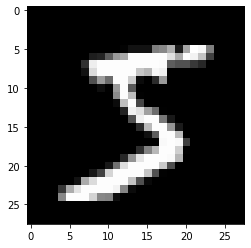

In [18]:
plt.imshow(train_X[0], cmap=plt.get_cmap('gray'))
plt.show()

In [30]:
# Preprocess
train_X = train_X.reshape(60000, 784)
test_X = test_X.reshape(10000, 784)
train_X = minmax_scale(train_X, feature_range=(0, 1))  # 0-1 scaling
test_X = minmax_scale(test_X, feature_range=(0, 1))  # 0-1 scaling

## <font color='darkblue'>Models definition</font>
We build a classification pipeline with a BernoulliRBM feature extractor and a [**LogisticRegression**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) classifier.

In [32]:
logistic = linear_model.LogisticRegression(solver="newton-cg", tol=1)
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(steps=[("rbm", rbm), ("logistic", logistic)])

## <font color='darkgreen'>Training</font>
The hyperparameters of the entire model (learning rate, hidden layer size, regularization) were optimized by grid search, but the search is not reproduced here because of runtime constraints.

In [35]:
%%time
# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 10

# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(train_X, train_y)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -95.47, time = 7.59s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -94.27, time = 8.89s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -94.15, time = 8.29s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -90.41, time = 8.35s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -93.81, time = 8.60s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -93.68, time = 9.45s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -94.91, time = 8.39s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -87.72, time = 8.38s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -91.29, time = 8.93s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -86.95, time = 9.11s


Pipeline(steps=[('rbm',
                 BernoulliRBM(learning_rate=0.06, n_components=100,
                              random_state=0, verbose=True)),
                ('logistic',
                 LogisticRegression(C=6000, solver='newton-cg', tol=1))])

In [37]:
%%time
# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.0
raw_pixel_classifier.fit(train_X, train_y)

LogisticRegression(C=100.0, solver='newton-cg', tol=1)

### <font color='darkgreen'>Evaluation</font>

In [40]:
pred_y = rbm_features_classifier.predict(test_X)
print(
    "Logistic regression using RBM features:\n%s\n"
    % (metrics.classification_report(test_y, pred_y))
)

Logistic regression using RBM features:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.94      0.92      0.93      1032
           3       0.93      0.93      0.93      1010
           4       0.94      0.93      0.94       982
           5       0.93      0.92      0.92       892
           6       0.96      0.96      0.96       958
           7       0.96      0.93      0.95      1028
           8       0.91      0.94      0.92       974
           9       0.91      0.93      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000




In [41]:
pred_y = raw_pixel_classifier.predict(test_X)
print(
    "Logistic regression using raw pixel features:\n%s\n"
    % (metrics.classification_report(test_y, pred_y))
)

Logistic regression using raw pixel features:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.96      0.97      0.96      1135
           2       0.91      0.89      0.90      1032
           3       0.90      0.91      0.91      1010
           4       0.93      0.93      0.93       982
           5       0.89      0.87      0.88       892
           6       0.94      0.95      0.94       958
           7       0.93      0.92      0.92      1028
           8       0.87      0.88      0.88       974
           9       0.91      0.91      0.91      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000




The features extracted by the [**BernoulliRBM**](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.BernoulliRBM.html#sklearn.neural_network.BernoulliRBM) help improve the classification accuracy with respect to the logistic regression on raw pixels.

In [45]:
rbm.components_.shape

(100, 784)

### <font color='darkgreen'>Plotting</font>

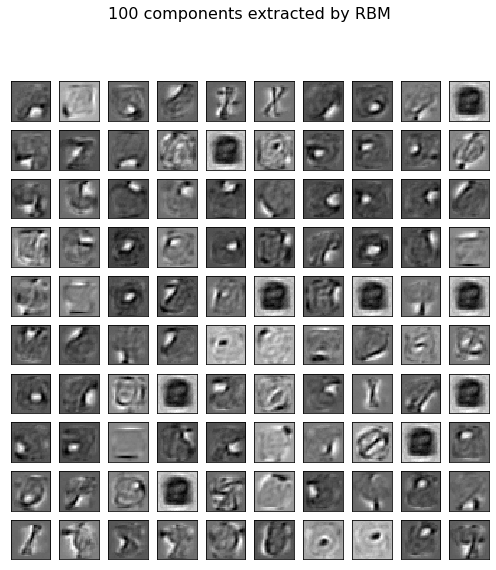

In [46]:
plt.figure(figsize=(8, 8))

for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
    
plt.suptitle("100 components extracted by RBM", fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

## <font color='darkblue'>Supplement</font>
* [MNIST Dataset in Python - Basic Importing and Plotting](https://www.digitalocean.com/community/tutorials/mnist-dataset-in-python)